### [E-11] 성능개선된 폐렴 진단기 프로젝트  

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.  
모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.  

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.  
regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이    ablation study 형태로 체계적으로 수행되었다.  

3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.  
Accuracy 기준 85%에 도달하였다.  

### 1. 실험 환경 세팅  
Batch size, Epoch 등을 변경  

#### 1. 필요한 라이브러리 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

#### 2. 필요한 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


#### 3. 데이터 가져오기

In [3]:
#
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

#train 안에는 5216개, test 안에는 624개, val 안에는 16개

#val 개수가 너무 없음  
#train에서 val로 조금 더 가져옴
#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

5216
624
16


#### 3. train, val 분리

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


#### 4. train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인

In [5]:
#정상, 폐렴 이미지 수 확인해보기 위해 파일 경로 확인  
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')   

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person614_bacteria_2483.jpeg


In [6]:
#정상, 쳬렴 이미지 수 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

#폐렴 이미지가 정상보다 3배 더 많이 있는 것 확인됨  
#데이터 불균형이 있다고 판단됨 
#CNN 모델은 클래스별 밸런스가 좋을 수록 학습 잘함 ㅎㅎ

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


#### 5. tf.data 인스턴스 생성   
tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해줌    
미니배치 왜 쓰는지 링크 : https://dambaekday.tistory.com/1  

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### 6. 라벨(y) 데이터 만들어주는 함수 생성

In [8]:
#train, val 데이터 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

# 라벨 데이터 따로 없이 그냥 모든 컬럼 데이터로 묶여 있음
# 폐렴이면=양성= T, 노말이면=음성 =F

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   

# 폐렴이면 양성(True), 노말이면 음성(False)

#### 7. 이미지 리사이즈  
이미지 데이터 사이즈 현실적으로 제각각일것  
이미지 사이즈 통일 + 효율적인 GPU 사용 위해 -> 이미지 사이즈 줄임  

- decode_img 함수 생성  
- process_path 함수 생성  
  : process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경 
- get_label:  라벨 값을 가져옴  

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
#X-RAY 이미지 사이즈 변수 : IMAGE_SIZE = [180, 180]
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

num_parallel_calls 파라미터에 위에서 할당한  
AUTOTUNE변수 이용하면 빠른 데이터 처리 가능  

In [11]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_ds : 빠르게 데이터 로드해와서, 이미지 리사이즈를 모든 train 이미지에 적용. 이 이미지들을 다 가져오는 변수
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

##### 8. 리사이즈, 라벨 확인해보기

In [12]:
#take() : 행,열  추출. iloc 보다 좀 더 빠른 성능 기대
#https://kongdols-room.tistory.com/181
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


#### 9.  test 데이터셋도 인스턴스 생성 ~리사이즈

In [13]:
#테스트 인스턴트 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
#테스트 라벨 데이터 만들어주기
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
#빠르게 이미지 리사이즈
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#위에서 배치사이즈 16으로 지정함  
test_ds = test_ds.batch(BATCH_SIZE)

#테스트 라벨 데이터 개수 = 624
print(TEST_IMAGE_COUNT)

624


#### 10 . 파이프라인 사용 함수 생성

* 파이프라인  
한 데이터 처리 단계의 출력이 다음 단계의 입력으로 이어지는 형태로 연결된 구조  
이렇게 연결된 데이터 처리 단계는 한 여러 단계가 서로 동시에,  
또는 병렬적으로 수행될 수 있어 효율적  
각 단계 사이의 입출력을 중계하기 위해 버퍼가 사용될 수 있음  


* Tensorflow에서는  
  tf.data 파이프라인을 사용해서  
  학습 데이터를 효율적으로 사용할 수 있도록 해줌 
  

In [14]:
def prepare_for_training_simple(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_simple = prepare_for_training_simple(train_ds)
val_ds_simple = prepare_for_training_simple(val_ds)

#### 11. 파이프라인 + augmentation 사용 함수 생성
* 의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않음  
  -> augmentation 기법 도입  
  -> 육안으로도 구분하기 어려운 미묘한 차이에  
     더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있음  
   -> 그래서 신중히 도입해야함   
   
랜덤하게 이미지 좌우반전 시켜줘서 데이터 많게 해줌  

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

In [16]:
#prepare_for_training() : tf.data 파이프라인 사용해서 정의

#shuffle() : 고정 크기 버퍼 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택  

#repeat() : 에포크 진행하면서 여러번 데이터 셋 불러오는데, 
#여러번 데이터셋을 사용의 경우 여러번 데이터 셋을 사용

#batch():  BATCH_SIZE에서 정한 만큼의 배치로 주어짐

#prefetch() : 학습 데이터 나눠서 읽어옴 
#(gpu에서 학습하는 동안 두번째 데이터 cpu에서 준비 가능)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_ag = prepare_for_training(train_ds)
val_ds_ag = prepare_for_training(val_ds)

### 3. 데이터 시각화  

train에 있는 batch 중 첫 번째 배치를 추출  
추출된 배치를 image와 label 데이터 셋으로 나눴던걸 각 인자로 가져옴  

##### 1) baseline_simple 시각화

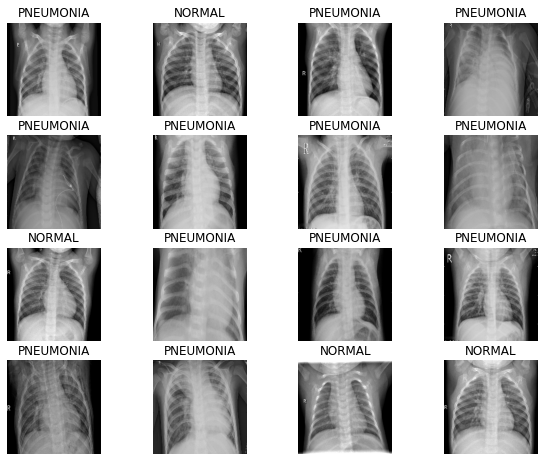

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch_simple(image_batch_simple, label_batch_simple):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch_simple[n])
        if label_batch_simple[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch_simple, label_batch_simple = next(iter(train_ds_simple))
show_batch_simple(image_batch_simple.numpy(), label_batch_simple.numpy())

##### 2)  baseline + augumentation 시각화

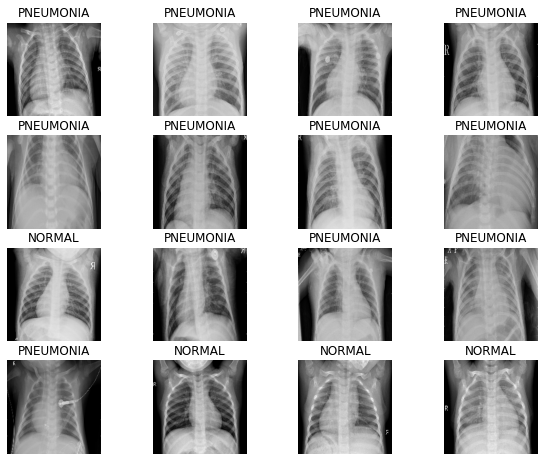

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch_ag(image_batch_ag, label_batch_ag):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch_ag[n])
        if label_batch_ag[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch_ag, label_batch_ag = next(iter(train_ds_ag))
show_batch_ag(image_batch_ag.numpy(), label_batch_ag.numpy())

### 4. CNN 모델링
CNN 요약 논문 : http://taewan.kim/post/cnn/

#### 1. conv block 생성

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), #BN : 그래디언트 배니싱/ 익스플로딩 해결
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

##### 2. Dense Block () = Fully connected 생성  (dropout+ BN 모두 포함)

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용
#일반적으로 동시에 사용하지 않지만
#예외적으로 같이 쓰기도 함
#두가지 함께 쓰는게 모델 성능 향상에 좋은지 아닌지 흥미롭게 볼 부분

#### 3.  Dense Block_dp () 생성_ BN 제외. Dropout만 포함

In [21]:
def dense_block_dp(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### 4. Dense Block_bn () 생성_ BN만 포함. Dropout은 제외

In [22]:
def dense_block_bn(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    
    return block

#### 3. 최종 모델 생성

##### 1) baseline_simple 모델 생성

In [23]:
def build_model_bs():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

##### 2) baseline + augumentation 모델 생성

In [24]:
def build_model_ba():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

##### 3) baseline + augumentation + dropout 만 적용한 Dense_block_dp() 모델 생성

In [25]:
def build_model_dp():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_dp(512, 0.7),
        dense_block_dp(128, 0.5),
        dense_block_dp(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

##### 4) baseline + augumentation + BN 만 적용한  Dense Block_bn () 생성

In [26]:
def build_model_bn():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_bn(512),
        dense_block_bn(128),
        dense_block_bn(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

##### 5) regulization.L2 모델 생성

In [27]:
def build_model_r():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ])
    
    return model

### 5. 데이터 imbalance 처리  

* 노멀과 폐렴중에 폐렴 데이터가 너무 많이 있었음 = imbalance 했음  

* 해결방법 =  Weight balancing 테크닉  
  - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
  - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.  
  - 상세 내용 : https://3months.tistory.com/414

In [28]:
#weight_for_0은 'Normal' 이미지에 사용할 weight
#weight_for_1은 'Pneumonia' 이미지에 사용할 weight
#weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

#러닝 레이트 설정 (데이터 개수 다르니까 러닝 레이트를 다르게 설정)
#지금 아래에서는 lr =2.0 으로 두고 있음  
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택  
모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언 

#### 조기종료= EarlyStopping 설정하기

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

##### 1) baseline_simple 모델 컴파일

In [30]:
with tf.device('/GPU:0'):
    model_bs = build_model_bs()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_bs.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

##### baseline_simple 모델 학습

In [31]:
with tf.device('/GPU:0'):
    history_bs = model_bs.fit(
        train_ds_simple,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_simple,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 84s 227ms/step - loss: 0.5005 - accuracy: 0.7334 - precision: 0.9293 - recall: 0.6985 - val_loss: 0.6967 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 57s 219ms/step - loss: 0.2132 - accuracy: 0.9222 - precision: 0.9789 - recall: 0.9148 - val_loss: 1.3230 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 221ms/step - loss: 0.1731 - accuracy: 0.9334 - precision: 0.9809 - recall: 0.9288 - val_loss: 0.2899 - val_accuracy: 0.8692 - val_precision: 0.8506 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 57s 220ms/step - loss: 0.1616 - accuracy: 0.9380 - precision: 0.9809 - recall: 0.9345 - val_loss: 0.1622 - val_accuracy: 0.9385 - val_precision: 0.9558 - val_recall: 0.9608
Epoch 5/25
261/261 [==============================] - 59s 226ms/step - loss: 0.1780 - accura

##### 2) baseline + augumentation 모델 컴파일 (dropout+BN +aug 모두적용)

In [32]:
with tf.device('/GPU:0'):
    model_ba = build_model_ba()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_ba.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#####  baseline + augumentation 모델 학습

In [33]:
with tf.device('/GPU:0'):
    history_ba = model_ba.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 70s 224ms/step - loss: 0.5278 - accuracy: 0.7297 - precision: 0.9166 - recall: 0.7001 - val_loss: 0.7031 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 224ms/step - loss: 0.2645 - accuracy: 0.8956 - precision: 0.9663 - recall: 0.8912 - val_loss: 0.9881 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 223ms/step - loss: 0.2178 - accuracy: 0.9187 - precision: 0.9760 - recall: 0.9137 - val_loss: 0.2304 - val_accuracy: 0.8942 - val_precision: 0.8750 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 59s 227ms/step - loss: 0.1495 - accuracy: 0.9436 - precision: 0.9829 - recall: 0.9399 - val_loss: 0.0824 - val_accuracy: 0.9673 - val_precision: 0.9692 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1867 - accura

##### 3) baseline + augumentation + dropout 만 적용한 Dense_block_dp() 모델 컴파일

In [34]:
with tf.device('/GPU:0'):
    model_dp = build_model_dp()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_dp.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

###### baseline + augumentation + dropout 만 적용한 Dense_block_dp() 모델 학습

In [35]:
with tf.device('/GPU:0'):
    history_dp = model_dp.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 68s 220ms/step - loss: 0.5075 - accuracy: 0.6890 - precision: 0.8884 - recall: 0.6684 - val_loss: 0.5889 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 57s 218ms/step - loss: 0.2738 - accuracy: 0.8821 - precision: 0.9688 - recall: 0.8704 - val_loss: 0.6772 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 57s 218ms/step - loss: 0.2177 - accuracy: 0.9059 - precision: 0.9780 - recall: 0.8921 - val_loss: 2.8067 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 00003: early stopping


#### 4) baseline + augumentation + BN 만 적용한  Dense Block_bn () 모델 컴파일

In [37]:
with tf.device('/GPU:0'):
    model_bn = build_model_bn()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_bn.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#### baseline + augumentation + BN 만 적용한  Dense Block_bn () 모델 학습

In [40]:
with tf.device('/GPU:0'):
    history_bn = model_bn .fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs= EPOCHS,   #EPOCHS
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 70s 224ms/step - loss: 0.3376 - accuracy: 0.8333 - precision: 0.9636 - recall: 0.8086 - val_loss: 0.6368 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 57s 217ms/step - loss: 0.1982 - accuracy: 0.9215 - precision: 0.9735 - recall: 0.9198 - val_loss: 1.1641 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 58s 221ms/step - loss: 0.1774 - accuracy: 0.9267 - precision: 0.9789 - recall: 0.9216 - val_loss: 0.6592 - val_accuracy: 0.7769 - val_precision: 0.7673 - val_recall: 1.0000
Epoch 00003: early stopping


##### 5) regulization.l2 모델 컴파일

In [41]:
with tf.device('/GPU:0'):
    model_r = build_model_r()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_r.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

#####  regulization.l2 모델 학습

In [42]:
with tf.device('/GPU:0'):
    history_r = model_r.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 68s 221ms/step - loss: 0.5671 - accuracy: 0.7175 - precision: 0.9076 - recall: 0.6862 - val_loss: 0.6163 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 222ms/step - loss: 0.2887 - accuracy: 0.8892 - precision: 0.9668 - recall: 0.8810 - val_loss: 0.8893 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 57s 217ms/step - loss: 0.1994 - accuracy: 0.9269 - precision: 0.9805 - recall: 0.9212 - val_loss: 0.6392 - val_accuracy: 0.7683 - val_precision: 0.7604 - val_recall: 1.0000
Epoch 00003: early stopping


### 7. 학습 결과 확인_ 시각화

##### 1) baseline_simple 결과 시각화 + test

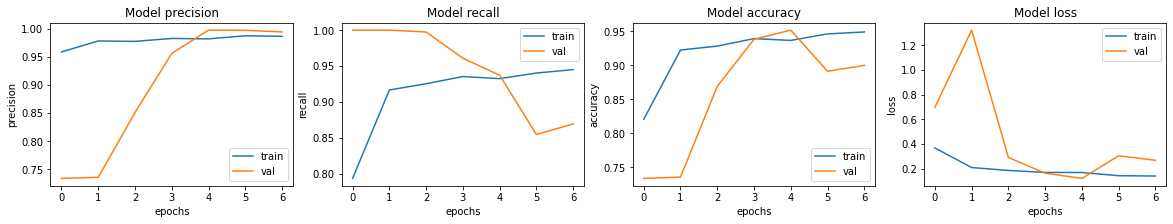

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_bs.history[met])
    ax[i].plot(history_bs.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [44]:
loss, accuracy, precision, recall = model_bs.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 141ms/step - loss: 0.4674 - accuracy: 0.8413 - precision: 0.8540 - recall: 0.9000
Loss: 0.467395544052124,
Accuracy: 0.8413461446762085,
Precision: 0.8540145754814148,
Recall: 0.8999999761581421


##### 2) baseline + augumentation 결과 시각화 + test

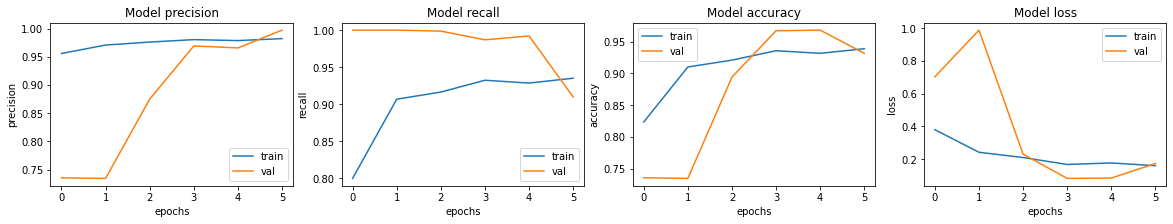

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_ba.history[met])
    ax[i].plot(history_ba.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [46]:
loss, accuracy, precision, recall = model_ba.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 141ms/step - loss: 0.3272 - accuracy: 0.8862 - precision: 0.8771 - recall: 0.9513
Loss: 0.32719138264656067,
Accuracy: 0.8862179517745972,
Precision: 0.8770685791969299,
Recall: 0.9512820243835449


##### 3) baseline + augumentation + dropout 만 적용한 Dense_block_dp() 결과 시각화 + test

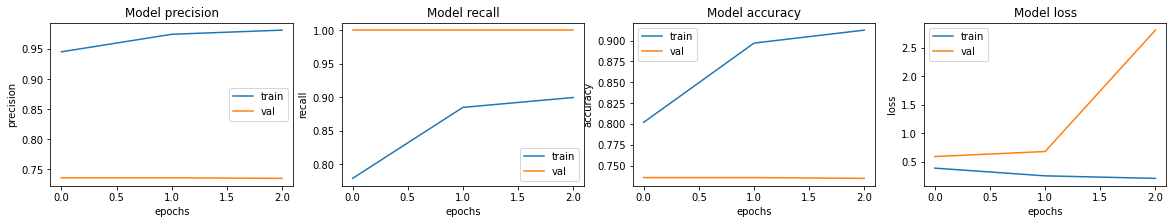

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_dp.history[met])
    ax[i].plot(history_dp.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
loss, accuracy, precision, recall = model_dp.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 142ms/step - loss: 5.7315 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 5.731468200683594,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


#### 4) baseline + augumentation + BN 만 적용한  Dense Block_bn () 결과 시각화 + test

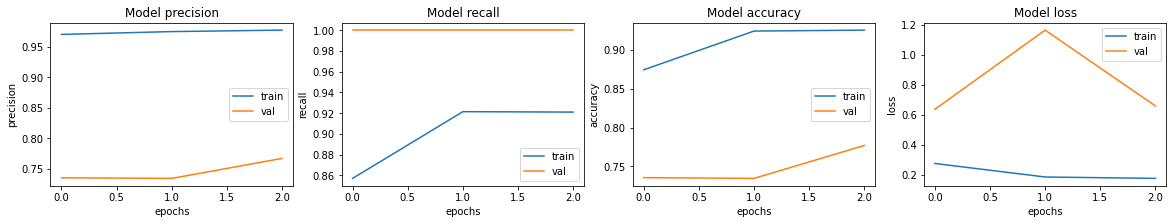

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_bn.history[met])
    ax[i].plot(history_bn.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [50]:
loss, accuracy, precision, recall = model_bn.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 141ms/step - loss: 1.5760 - accuracy: 0.6266 - precision: 0.6260 - recall: 1.0000
Loss: 1.5760153532028198,
Accuracy: 0.6266025900840759,
Precision: 0.6260032057762146,
Recall: 1.0


##### 5) regulization.l2 결과 시각화 + test

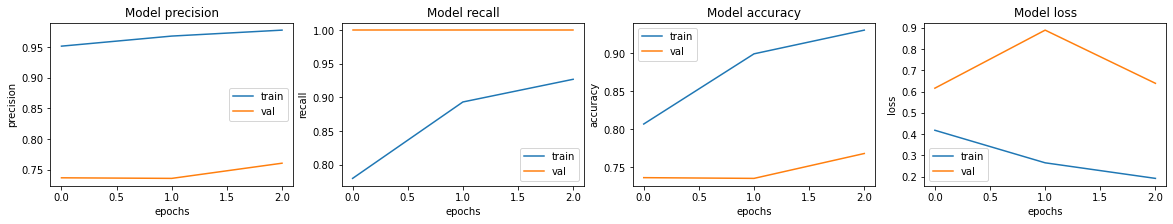

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_r.history[met])
    ax[i].plot(history_r.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, accuracy, precision, recall = model_r.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 142ms/step - loss: 1.3109 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 1.3108996152877808,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 8. 테스트 결과  
- baseline + augumentation 모델이 88% 정확도로 가장 성능이 좋음  
  dropout, BN, regulization.l2 정확도를 보면 train,val가 오버피팅이 되는 것 같아 보임

### 회고



#### 💚루브릭  
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.  
- 모델 학습이 안정적으로 수렴하는 것을 시각화로 확인함  

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.  
- regularization, augmentation 등의 기법의 사용 여부에 따른  
  모델 성능 측정이 ablation study 형태로 체계적으로 수행됨  
  
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다  
- Accuracy 기준 85% 이상으로 도달함  

#### 💚배운점  
- 이번 프로젝트로 dropout, BN, regulization.l2 등  
  원하는대로 레이어를 쌓을 수 있어서 재밌었다  